# 19K Matches from "EUW1" region and patch 11.23 were used to analyze Items and champions League of Legends game. Here is the process.

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 31.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=159cea8abd1d9073940c1474c4a90d64c8f3746ae20e873c8dea97de4dd0266f
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
from google.colab import drive
from pyspark import SparkContext
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json, pyspark

## Read data parallelized

In [ ]:
spark = SparkSession.builder.master("local[1]").appName("lol").getOrCreate()

In [ ]:
df = spark.read.json("/content/drive/MyDrive/My year 5/Big Data/MP2/big_matches_data.json", multiLine=True)

In [ ]:
data_rdd = df.rdd

## Data dragon
### Champions

In [ ]:
with open("/content/drive/MyDrive/My year 5/Big Data/MP2/data dragon/champions.json") as f:
    dragon_data = json.load(f)
dragon_champions = list(dragon_data["data"].values())

In [ ]:
def championId_to_name_and_class(record):
    id = int(record["key"])
    ch_class = record["tags"][0]
    name = record["name"]
    return (id, (name, ch_class))

In [ ]:
champion_dragon_mapping = list(map(championId_to_name_and_class, dragon_champions))
champion_dragon_mapping[0]

(266, ('Aatrox', 'Fighter'))

In [ ]:
champion_dragon_dict = {element[0]: element[1] for element in champion_dragon_mapping}
champion_dragon_dict

{1: ('Annie', 'Mage'),
 2: ('Olaf', 'Fighter'),
 3: ('Galio', 'Tank'),
 4: ('Twisted Fate', 'Mage'),
 5: ('Xin Zhao', 'Fighter'),
 6: ('Urgot', 'Fighter'),
 7: ('LeBlanc', 'Assassin'),
 8: ('Vladimir', 'Mage'),
 9: ('Fiddlesticks', 'Mage'),
 10: ('Kayle', 'Fighter'),
 11: ('Master Yi', 'Assassin'),
 12: ('Alistar', 'Tank'),
 13: ('Ryze', 'Mage'),
 14: ('Sion', 'Tank'),
 15: ('Sivir', 'Marksman'),
 16: ('Soraka', 'Support'),
 17: ('Teemo', 'Marksman'),
 18: ('Tristana', 'Marksman'),
 19: ('Warwick', 'Fighter'),
 20: ('Nunu & Willump', 'Tank'),
 21: ('Miss Fortune', 'Marksman'),
 22: ('Ashe', 'Marksman'),
 23: ('Tryndamere', 'Fighter'),
 24: ('Jax', 'Fighter'),
 25: ('Morgana', 'Mage'),
 26: ('Zilean', 'Support'),
 27: ('Singed', 'Tank'),
 28: ('Evelynn', 'Assassin'),
 29: ('Twitch', 'Marksman'),
 30: ('Karthus', 'Mage'),
 31: ("Cho'Gath", 'Tank'),
 32: ('Amumu', 'Tank'),
 33: ('Rammus', 'Tank'),
 34: ('Anivia', 'Mage'),
 35: ('Shaco', 'Assassin'),
 36: ('Dr. Mundo', 'Fighter'),
 37: ('S

### Items

In [ ]:
with open("/content/drive/MyDrive/My year 5/Big Data/MP2/data dragon/item.json") as f:
    dragon_items = json.load(f)

In [ ]:
item_dict = {}
for id in dragon_items["data"]:
    item_dict[id] = dragon_items["data"][id]["name"]

In [ ]:
item_dict

{'1001': 'Boots',
 '1004': 'Faerie Charm',
 '1006': 'Rejuvenation Bead',
 '1011': "Giant's Belt",
 '1018': 'Cloak of Agility',
 '1026': 'Blasting Wand',
 '1027': 'Sapphire Crystal',
 '1028': 'Ruby Crystal',
 '1029': 'Cloth Armor',
 '1031': 'Chain Vest',
 '1033': 'Null-Magic Mantle',
 '1035': 'Emberknife',
 '1036': 'Long Sword',
 '1037': 'Pickaxe',
 '1038': 'B. F. Sword',
 '1039': 'Hailblade',
 '1040': 'Obsidian Edge',
 '1042': 'Dagger',
 '1043': 'Recurve Bow',
 '1052': 'Amplifying Tome',
 '1053': 'Vampiric Scepter',
 '1054': "Doran's Shield",
 '1055': "Doran's Blade",
 '1056': "Doran's Ring",
 '1057': 'Negatron Cloak',
 '1058': 'Needlessly Large Rod',
 '1082': 'Dark Seal',
 '1083': 'Cull',
 '2003': 'Health Potion',
 '2010': 'Total Biscuit of Everlasting Will',
 '2015': 'Kircheis Shard',
 '2031': 'Refillable Potion',
 '2033': 'Corrupting Potion',
 '2051': "Guardian's Horn",
 '2052': 'Poro-Snax',
 '2055': 'Control Ward',
 '2065': "Shurelya's Battlesong",
 '2138': 'Elixir of Iron',
 '2139

## First requirement: Champion win, pick, ban rates

### Ban rates

In [ ]:
def record_to_champion_ban(record):
    team1, team2 = record["info"]["teams"]
    bans_ids = [(ban[0],1) for ban in team1["bans"]]
    bans_ids.extend([(ban[0],1) for ban in team2["bans"]])
    # each ban maps to (champion_id, 1 for each ban)
    return bans_ids

In [ ]:
bans_per_champion = data_rdd.flatMap(record_to_champion_ban).reduceByKey(lambda a,b: a+b)

In [ ]:
bans_per_champion_sorted = bans_per_champion.sortBy(lambda x: x[1], ascending = False)
top_banned = bans_per_champion_sorted.take(6)

visualizing

In [ ]:
top_banned

[(350, 12855), (91, 9821), (38, 7896), (-1, 7168), (238, 6077), (777, 5871)]

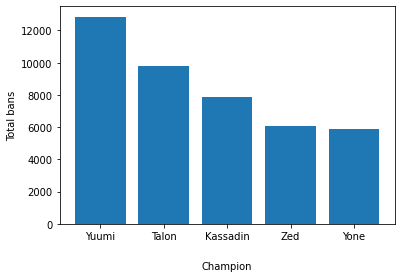

In [ ]:
names = []
bans = []
for id, ban in top_banned:
    if id == -1:
        continue
    names.append(champion_dragon_dict[id][0])
    bans.append(ban)

plt.bar(names,bans);
plt.xlabel("Champion", labelpad = 20);
plt.ylabel("Total bans");

### pick rates
Actual pick rate = $pick\space count/ matches\space count$

In [ ]:
def record_to_champion_pick(record):
    participants = record["info"]["participants"]
    mapped = list(map(lambda participant: (participant["championId"],1), participants))
    # each player maps to (champion_id, 1 for each pick)
    return mapped

In [ ]:
picks_per_champion = data_rdd.flatMap(record_to_champion_pick).reduceByKey(lambda a,b:a+b).sortBy(lambda x: x[1], ascending = False)
top_picks = picks_per_champion.take(5)

visualizing

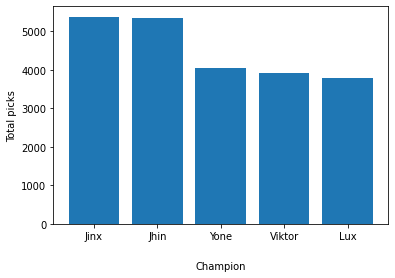

In [ ]:
names = []
picks = []
for id, pick in top_picks:
    if id == -1:
        continue
    names.append(champion_dragon_dict[id][0])
    picks.append(pick)

plt.bar(names,picks);
plt.xlabel("Champion", labelpad = 20);
plt.ylabel("Total picks");

### Win rates
Out of the times a champion was picked, how many times has it won

In [ ]:
def record_to_champion_pick_and_win(record):
    participants = record["info"]["participants"]
    mapped = list(map(lambda p: (p["championId"],(int(p["win"]), 1)), participants))
    # each player maps to (champion_id, (0/1 for win, 1 for pick))
    return mapped

In [ ]:
win_and_picks = data_rdd.flatMap(record_to_champion_pick_and_win).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
win_and_picks.take(1)

[(57, (232, 435))]

Some champions can have win rates of 1.0. This can be due to their existence only a few times in the dataset. **So a champion that appears once, and wins, will have a win rate of 1.0!**

As such, we will filter out any champion with less than 100 wins

In [ ]:
# get the win rate (win count / pick count)
win_rate = win_and_picks.filter(lambda x: x[1][0] > 100).map(lambda x: (x[0], x[1][0]/x[1][1])).sortBy(lambda x: x[1], ascending = False) # threshold the wins above 100. 
top_winners = win_rate.take(5)

visualizing

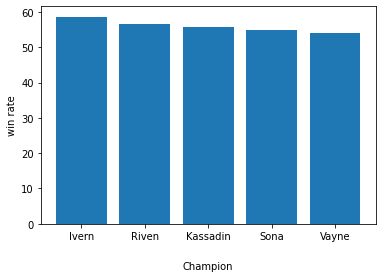

In [ ]:
names = []
wins = []
for id, win in top_winners:
    if id == -1:
        continue
    names.append(champion_dragon_dict[id][0])
    wins.append(win*100)

plt.bar(names,wins);
plt.xlabel("Champion", labelpad = 20);
plt.ylabel("win rate");

## Second Requirement: Champion synergies
This can be measured by the win rate of champion duos

In [ ]:
def record_to_duo(record):
    participants = record["info"]["participants"]
    
    # get all duos of team 1 (duo, 1/0 for win, 1 for pick)
    team1_players = participants[:5]
    is_team_1_win = int(team1_players[0]["win"])
    team_1_champions = list(map(lambda p: p["championId"], team1_players))
    team_1_duos = []
    for i in range(5):
        for j in range(i+1,5):
            duo = [team_1_champions[i], team_1_champions[j]]
            duo = sorted(duo) # to make sure the duo appear in the same order, to be reduced correctly
            team_1_duos.append(tuple(duo)) 
    team_1_mapped = list(map(lambda duo: (duo, (is_team_1_win, 1)), team_1_duos))

    # get all duos of team 2 (duo, 1/0 for win, 1 for pick)
    team2_players = participants[5:]
    team_2_champions = list(map(lambda p: p["championId"], team2_players))
    team_2_duos = []
    for i in range(5):
        for j in range(i+1,5):
            duo = [team_2_champions[i], team_2_champions[j]]
            duo = sorted(duo) # to make sure the duo appear in the same order, to be reduced correctly
            team_2_duos.append(tuple(duo))
    team_2_mapped = list(map(lambda duo: (duo, (1-is_team_1_win, 1)), team_2_duos))

    return team_1_mapped + team_2_mapped

In [ ]:
duos_wins_and_picks = data_rdd.flatMap(record_to_duo).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
duos_wins_and_picks.take(1)

[((56, 57), (4, 7))]

once again, we try to filter out outliers by discarding duos with less than 10 picks

In [ ]:
duo_syn = duos_wins_and_picks.filter(lambda x: x[1][1] > 100).map(lambda x: (x[0], x[1][0]/x[1][1])).sortBy(lambda x: x[1], ascending = False)
top_duos = duo_syn.take(5)

visualization

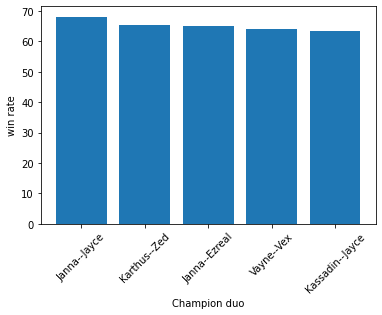

In [ ]:
duos = []
wins = []
for duo, win in top_duos:
    duo_1 = champion_dragon_dict[duo[0]][0]
    duo_2 = champion_dragon_dict[duo[1]][0]
    duos.append(duo_1+"--"+duo_2)
    wins.append(win *100)

plt.bar(duos, wins);
plt.xticks(rotation = 45);
plt.xlabel("Champion duo");
plt.ylabel("win rate");

## Third requirement Items 

In [ ]:
def record_to_item_winpick(record):
    participants = record["info"]["participants"]
    items = []
    for i in range(7):
        items_i = list(map(lambda p: (p[f"item{i}"], (int(p["win"]), 1)), participants))
        items += items_i
    # each player maps to (item_id, (0/1 for win, 1 for pick))
    return items

In [ ]:
winsAndPicks_per_item = data_rdd.flatMap(record_to_item_winpick).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).cache()
winsAndPicks_per_item.take(5)

[(0, (49343, 113460)),
 (3814, (2189, 3609)),
 (3020, (18134, 35618)),
 (3006, (17610, 34786)),
 (3860, (3642, 7000))]

### sorting based on wins

In [ ]:
items_by_wins = data_rdd.flatMap(record_to_item_winpick).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).sortBy(lambda x: x[1][0], ascending = False)
items_by_wins.take(5)

[(0, (49343, 113460)),
 (3364, (41312, 80562)),
 (3340, (27011, 58055)),
 (3363, (26683, 51435)),
 (3158, (20206, 38657))]

### sorting based on picks (Pick rate)

In [ ]:
items_by_picks = data_rdd.flatMap(record_to_item_winpick).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).sortBy(lambda x: x[1][1], ascending = False)
items_by_picks.take(5)

[(0, (49343, 113460)),
 (3364, (41312, 80562)),
 (3340, (27011, 58055)),
 (3363, (26683, 51435)),
 (3047, (19809, 39782))]

### win rate
getting the win rate (win count / pick count)

In [ ]:
item_win_rate = winsAndPicks_per_item.map(lambda x: (x[0], x[1][0]/x[1][1])).sortBy(lambda x: x[1], ascending = False)
item_win_rate.take(50)

[(7022, 1.0),
 (3513, 0.7948717948717948),
 (3041, 0.7941442255557564),
 (7016, 0.75),
 (7021, 0.7272727272727273),
 (7000, 0.7058823529411765),
 (7020, 0.7027027027027027),
 (7002, 0.6923076923076923),
 (7007, 0.6875),
 (7013, 0.684931506849315),
 (4643, 0.6736064472800537),
 (7015, 0.6538461538461539),
 (6035, 0.6506849315068494),
 (3400, 0.6477272727272727),
 (3222, 0.6421052631578947),
 (7008, 0.6386554621848739),
 (3026, 0.6362541403191809),
 (3139, 0.6306068601583114),
 (7009, 0.625),
 (7001, 0.6231884057971014),
 (7006, 0.6222222222222222),
 (3050, 0.6162483487450462),
 (3109, 0.6139682539682539),
 (3814, 0.6065392075367138),
 (3107, 0.606353591160221),
 (3504, 0.6053962900505903),
 (6616, 0.593143596377749),
 (3193, 0.5918367346938775),
 (7005, 0.5894308943089431),
 (7011, 0.5892857142857143),
 (3102, 0.5886699507389163),
 (7003, 0.5882352941176471),
 (4638, 0.5875),
 (3083, 0.5873015873015873),
 (6333, 0.58482216030159),
 (3089, 0.584228985179319),
 (3072, 0.583752093802345),


## Requirement 4 Item synergies

### Item with champion synergies

In [ ]:
def record_to_itemChamp_winpick(record):
    participants = record["info"]["participants"]
    items = []
    for i in range(7):
        items_i = list(map(lambda p: ((p["championId"], p[f"item{i}"]), (int(p["win"]), 1)), participants))
        items += items_i
    # each player maps to ((champ_id, item_id), (0/1 for win, 1 for pick))
    return items

In [ ]:
itemChamp_duo = data_rdd.flatMap(record_to_itemChamp_winpick).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
itemChamp_duo.take(5)

[((57, 0), (92, 209)),
 ((56, 3814), (82, 152)),
 ((134, 3020), (590, 1255)),
 ((110, 3006), (62, 107)),
 ((44, 3860), (117, 228))]

In [ ]:
itemChamp_winrate = itemChamp_duo.map(lambda x: (x[0], x[1][0]/x[1][1])).sortBy(lambda x: x[1], ascending = False)
itemChamp_winrate.take(10)

[((141, 3153), 1.0),
 ((141, 3742), 1.0),
 ((31, 3006), 1.0),
 ((56, 3181), 1.0),
 ((8, 1033), 1.0),
 ((134, 1033), 1.0),
 ((69, 7014), 1.0),
 ((142, 2422), 1.0),
 ((235, 7001), 1.0),
 ((2, 3117), 1.0)]

In [ ]:
itemChamp_pickSorted = itemChamp_duo.sortBy(lambda x: x[1][1], ascending = False)
itemChamp_pickSorted.take(10)

[((222, 3006), (2623, 5091)),
 ((202, 6671), (2577, 5086)),
 ((202, 3363), (2309, 4453)),
 ((222, 3363), (2308, 4290)),
 ((202, 3009), (2078, 4104)),
 ((202, 0), (1747, 3945)),
 ((777, 3006), (1958, 3905)),
 ((777, 6673), (1957, 3790)),
 ((222, 0), (1681, 3735)),
 ((51, 3006), (1694, 3383))]

### Item with class synergies

In [ ]:
def record_to_itemClass_winpick(record):
    participants = record["info"]["participants"]
    items = []
    
    for i in range(7):
        items_i = list(map(lambda p: ((champion_dragon_dict[p["championId"]][1], p[f"item{i}"]), (int(p["win"]), 1)), participants))
        items += items_i
    # each player maps to ((class, item_id), (0/1 for win, 1 for pick))
    return items

In [ ]:
itemClass_duo = data_rdd.flatMap(record_to_itemClass_winpick).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
itemClass_duo.take(5)

[(('Tank', 0), (4301, 9564)),
 (('Assassin', 3814), (1299, 2081)),
 (('Mage', 3020), (11283, 22181)),
 (('Marksman', 3006), (12054, 23639)),
 (('Support', 3860), (1461, 2716))]

In [ ]:
itemClass_duo = data_rdd.flatMap(record_to_itemClass_winpick).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
itemClass_duo.take(5)

[(('Tank', 0), (4301, 9564)),
 (('Assassin', 3814), (1299, 2081)),
 (('Mage', 3020), (11283, 22181)),
 (('Marksman', 3006), (12054, 23639)),
 (('Support', 3860), (1461, 2716))]

In [ ]:
itemClass_pickSorted = itemClass_duo.sortBy(lambda x: x[1][1], ascending = False)
itemClass_pickSorted.take(10)

[(('Marksman', 3363), (14970, 28785)),
 (('Marksman', 0), (12034, 28666)),
 (('Fighter', 0), (11475, 26231)),
 (('Fighter', 3340), (11496, 24090)),
 (('Marksman', 3006), (12054, 23639)),
 (('Mage', 3020), (11283, 22181)),
 (('Assassin', 3364), (10439, 20343)),
 (('Fighter', 3047), (9499, 19118)),
 (('Support', 3364), (9759, 18941)),
 (('Assassin', 0), (8111, 18925))]

## Item Suggestion
Given a champion's id, we will return an ordered list of the suggested items. These items are sorted by their synergy with this champion (items with highest win rate for this specific champion)

In [ ]:
def get_champion_best_itmes(champion_id):
    return itemChamp_winrate.filter(lambda x: x[0][0] == champion_id).sortBy(lambda x: x[1], ascending = False).collect()

In [ ]:
get_champion_best_itmes(222)

[((222, 6333), 1.0),
 ((222, 3211), 1.0),
 ((222, 6695), 1.0),
 ((222, 3400), 1.0),
 ((222, 3124), 1.0),
 ((222, 3508), 1.0),
 ((222, 3057), 1.0),
 ((222, 4633), 1.0),
 ((222, 3003), 1.0),
 ((222, 3041), 1.0),
 ((222, 3156), 0.782608695652174),
 ((222, 3157), 0.75),
 ((222, 2424), 0.75),
 ((222, 1033), 0.7391304347826086),
 ((222, 1029), 0.7272727272727273),
 ((222, 2421), 0.7272727272727273),
 ((222, 7006), 0.7272727272727273),
 ((222, 3026), 0.7003484320557491),
 ((222, 3134), 0.7),
 ((222, 3139), 0.6829268292682927),
 ((222, 7007), 0.6666666666666666),
 ((222, 6692), 0.6666666666666666),
 ((222, 3082), 0.6666666666666666),
 ((222, 3513), 0.6666666666666666),
 ((222, 3814), 0.6666666666666666),
 ((222, 3072), 0.6243243243243243),
 ((222, 1038), 0.618848167539267),
 ((222, 2420), 0.6153846153846154),
 ((222, 3133), 0.6),
 ((222, 3153), 0.6),
 ((222, 3031), 0.5975341259357111),
 ((222, 3046), 0.5826155050900548),
 ((222, 3095), 0.58),
 ((222, 3140), 0.576271186440678),
 ((222, 3047), 0

## Extra requirement: 
Check player activity per time. This can be useful for estimating how many servers should be provided, to save utilization, without affecting player experience

In [ ]:
import datetime

In [ ]:
def record_to_hour(record):
    epoch_time = record["info"]["gameCreation"]//1000
    mytimestamp = datetime.datetime.fromtimestamp( epoch_time )  
    # using strftime() function to convert timestamp to just an hour
    match_starting_hour = int(mytimestamp.strftime("%H"))
    return [(match_starting_hour, 1)]

In [ ]:
matches_starting_hours = data_rdd.flatMap(record_to_hour).reduceByKey(lambda a,b:a+b).sortBy(lambda x: x[0], ascending = True)
gamesPerHour = matches_starting_hours.collect()

In [ ]:
gamesPerHour

[(0, 607),
 (1, 398),
 (2, 261),
 (3, 175),
 (4, 141),
 (5, 143),
 (6, 142),
 (7, 192),
 (8, 264),
 (9, 436),
 (10, 694),
 (11, 945),
 (12, 1128),
 (13, 1278),
 (14, 1333),
 (15, 1378),
 (16, 1342),
 (17, 1285),
 (18, 1191),
 (19, 1240),
 (20, 1322),
 (21, 1259),
 (22, 1065),
 (23, 890)]

In [ ]:
hours = [str(h[0]) for h in gamesPerHour]
games = [h[1] for h in gamesPerHour]

We will rotate the lists to make the figure more visually appealing

In [ ]:
def rotate(l, n):
    return l[n:] + l[:n]

In [ ]:
hours = rotate(hours, 5)
games = rotate(games, 5)

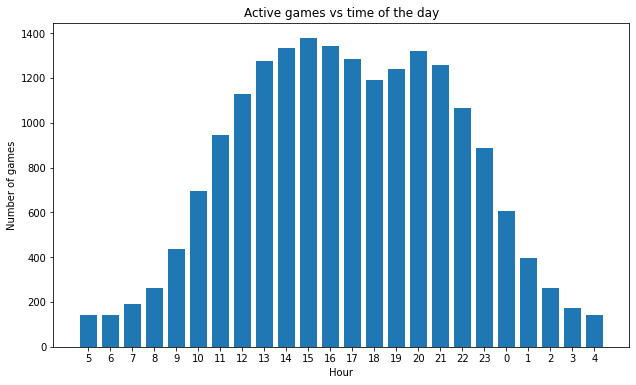

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,4.5))
ax = fig.add_axes([0,0,1,1])
plt.bar(hours,games)
plt.title("Active games vs time of the day");
plt.xlabel("Hour");
plt.ylabel("Number of games");